In this notebook we illustrate the use of our cythonized version of the EM algorithm.
The structure is the same as the class `GaussianMixture` of Scikit Learn.

In the first part we visualise the results in 1D and 2D. In the second part we record training on datasets of increasing complexity. Finally we illustrate the use of the EM approximation of GMMS on the color transport task.

# Visualisation

In [2]:
import time
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
import sklearn.mixture  
print(sklearn.__version__)

# Our package for ParallelEM
import sys
sys.path.insert(0, "./functions")
from EMbase import GaussianMixture

0.22.1


## 1D Visualisation

### Helper functions

In [2]:
def pdf(data, mean: float, variance: float):
    '''A normal continuous random variable.'''
        
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(data - mean)/(2*variance)))
    return s1 * s2


def sample(n_samples=100,delta=4, plot=False):
    """Draw n_samples from three gaussian distributions and stack them
    to form a GMM. Delta is the distance between the mean of the 3 components"""
    
    mu1, sigma1 = -delta, 1.2 
    mu2, sigma2 = delta, 1.8 
    mu3, sigma3 = 0, 1.6 

    x1 = np.random.normal(mu1, np.sqrt(sigma1), n_samples)
    x2 = np.random.normal(mu2, np.sqrt(sigma2), n_samples)
    x3 = np.random.normal(mu3, np.sqrt(sigma3), n_samples)

    X = np.array(list(x1) + list(x2) + list(x3))
    np.random.shuffle(X)
    

    if plot:
        print("Dataset shape:", X.shape)
        
        bins = np.linspace(np.min(X),np.max(X),100)

        fig = plt.figure(figsize=(10,7))
        plt.xlabel("$x$")
        plt.ylabel("pdf")
        plt.scatter(X, [0.005] * len(X), color='navy', s=30, marker=2, label="Train data")

        plt.plot(bins, pdf(bins, mu1, sigma1), color='red', label="True pdf")
        plt.plot(bins, pdf(bins, mu2, sigma2), color='red')
        plt.plot(bins, pdf(bins, mu3, sigma3), color='red')

        plt.legend()
        plt.plot()
        
    return X, [mu1, mu2, mu3], [sigma1, sigma2, sigma3]
        
    
def plot_results(X,mu,sigma,mean,variances):
    
    mu1, mu2, mu3 = mu
    sigma1, sigma2, sigma3 = sigma

    plt.figure(figsize=(10,6))
    axes = plt.gca()
    plt.xlabel("$x$")
    plt.ylabel("pdf")
    
    bins = np.linspace(np.min(X),np.max(X),100)
    
    plt.scatter(X, [0.005] * len(X), color='navy', s=30, marker=2, label="Train data")

    plt.plot(bins, pdf(bins, mu1, sigma1), color='grey', label="True pdf")
    plt.plot(bins, pdf(bins, mu2, sigma2), color='grey')
    plt.plot(bins, pdf(bins, mu3, sigma3), color='grey')

    plt.plot(bins, pdf(bins, means[0], variances[0]).reshape(-1), color='blue', label="Cluster 1")
    plt.plot(bins, pdf(bins, means[1], variances[1]).reshape(-1), color='green', label="Cluster 2")
    plt.plot(bins, pdf(bins, means[2], variances[2]).reshape(-1), color='magenta', label="Cluster 3")

    plt.legend(loc='upper left')

    plt.show()

Dataset shape: (300,)
Log Likelihood : -2.218402550054129 (10/100)
Convergence in 10 iterations
Computational time for EM: 0.0052678585052490234


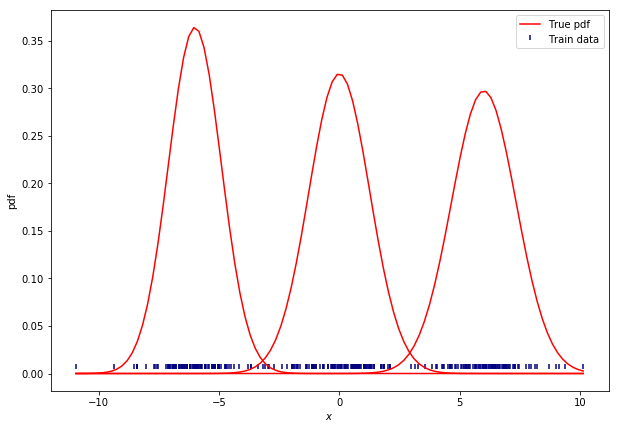

In [3]:
X, mu, sigma = sample(delta=6,plot=True)

tic = time.time()
gmm = GaussianMixture(n_components=3, verbose=1, tol=1e-5).fit(X.reshape(-1,1))
print("Computational time for EM: {}".format(time.time()-tic))
means = gmm.means_
variances = gmm.covariances_

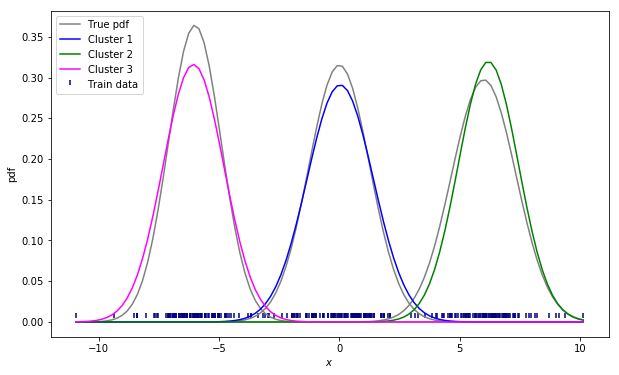

In [4]:
plot_results(X,mu,sigma,means,variances)

In [5]:
# Comparison of the estimated coefficients
print("True means", mu)
print("Estimated means", means.reshape(-1), end="\n\n")

print("True Covariances", sigma)
print("Estimated Covariances", variances.reshape(-1), end="\n\n")

print("Estimated weights: {} (true weights are uniform)".format(gmm.weights_))

True means [-6, 6, 0]
Estimated means [ 0.03665305  6.19144064 -6.06042301]

True Covariances [1.2, 1.8, 1.6]
Estimated Covariances [1.88004219 1.55770902 1.59356143]

Estimated weights: [0.336522   0.32900742 0.33447058] (true weights are uniform)


It's is important to note that the EM algorithm will perform badly if the components overlap too much. The above example behave well as the components are well separated. On the next example we see that it does not always works that fine.

Log Likelihood : -1.304723156622269 (10/100)
Log Likelihood : -1.3037136665701345 (20/100)
Log Likelihood : -1.3034538004197638 (30/100)
Convergence in 37 iterations
Computational time for EM: 0.0263979434967041


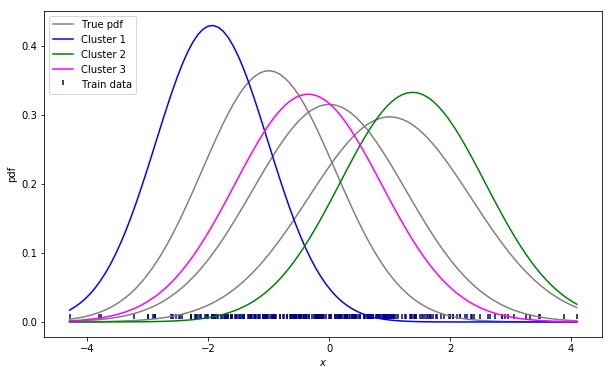

In [6]:
X, mu, sigma = sample(delta=1,plot=False)
tic = time.time()
gmm = GaussianMixture(n_components=3, verbose=1, tol=1e-5).fit(X.reshape(-1,1))
print("Computational time for EM: {}".format(time.time()-tic))
means = gmm.means_
variances = gmm.covariances_
plot_results(X,mu,sigma,means,variances)

# 2D Visualisation

In [7]:
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal

In [8]:
def sample_2D(n_samples):

    t_means = [[8.4, 8.2], [1.4, 1.6], [2.4, 5.4], [6.4, 2.4]]
    t_covs = []
    for s in range(len(t_means)):
        t_covs.append(make_spd_matrix(2))

    X = []
    for mean, cov in zip(t_means,t_covs):
        x = np.random.multivariate_normal(mean, cov, n_samples)
        X += list(x)

    X = np.array(X)
    np.random.shuffle(X)
    print("Dataset shape:", X.shape)
    
    return X, np.array(t_means), np.array(t_covs)

In [9]:
X, mu, sigma = sample_2D(100)
K = 4
tic = time.time()
gmm = GaussianMixture(n_components=K, verbose=1, tol=1e-5).fit(X)
print(time.time()-tic)
means = gmm.means_
cov = gmm.covariances_

Dataset shape: (400, 2)
Log Likelihood : -2.8249590370890765 (10/100)
Convergence in 19 iterations
0.016954898834228516


In [10]:
def plot_result_2D(X, means, cov):

    # Create a grid for visualization purposes 
    x = np.linspace(np.min(X[...,0])-1,np.max(X[...,0])+1,100)
    y = np.linspace(np.min(X[...,1])-1,np.max(X[...,1])+1,80)
    X_,Y_ = np.meshgrid(x,y)
    pos = np.array([X_.flatten(),Y_.flatten()]).T

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'magenta', 'yellow', 'red', 'brown', 'grey']
    eps=1e-8

    plt.figure(figsize=(12,int(8)))
    axes = plt.gca()

    likelihood = []
    for j in range(K):
        likelihood.append(multivariate_normal.pdf(x=pos, mean=means[j], cov=cov[j]))
    likelihood = np.array(likelihood)
    predictions = np.argmax(likelihood, axis=0)

    for c in range(K):
        pred_ids = np.where(predictions == c)
        plt.scatter(pos[pred_ids[0],0], pos[pred_ids[0],1], color=colors[c], alpha=0.2, edgecolors='none', marker='s')

    plt.scatter(X[...,0], X[...,1], facecolors='none', edgecolors='grey')

    for j in range(K):
        plt.scatter(means[j][0], means[j][1], color=colors[j])

    plt.show()

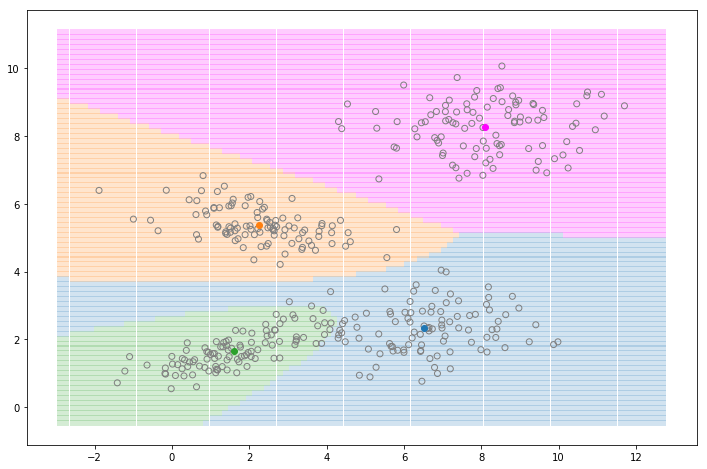

In [11]:
plot_result_2D(X, means, cov)

In [12]:
# Comparison of the estimated coefficients
print("True means")
pprint(mu)
print("Estimated means")
pprint(means)

print("True Covariances")
pprint(sigma)
print("Estimated Covariances")
pprint(cov)

print("Estimated weights: {} (true weights are uniform)".format(gmm.weights_))

True means
array([[8.4, 8.2],
       [1.4, 1.6],
       [2.4, 5.4],
       [6.4, 2.4]])
Estimated means
array([[6.51407393, 2.32361309],
       [2.23970906, 5.37954252],
       [1.60200129, 1.65297382],
       [8.10618383, 8.27337875]])
True Covariances
array([[[ 2.51359676, -0.05793319],
        [-0.05793319,  0.49742736]],

       [[ 1.95975427,  0.52219973],
        [ 0.52219973,  0.24976136]],

       [[ 2.15050108, -0.30795225],
        [-0.30795225,  0.22900766]],

       [[ 2.44226032,  0.16585803],
        [ 0.16585803,  0.46439732]]])
Estimated Covariances
array([[[ 2.18684544,  0.08388517],
        [ 0.08388517,  0.46371277]],

       [[ 1.71899445, -0.33008652],
        [-0.33008652,  0.26152093]],

       [[ 1.60486785,  0.49214179],
        [ 0.49214179,  0.26548629]],

       [[ 2.40823389,  0.06181233],
        [ 0.06181233,  0.55630776]]])
Estimated weights: [0.24888679 0.24992768 0.25116866 0.25001687] (true weights are uniform)


# Computational Times

In [19]:
from timeit import Timer
import numpy

In [20]:
def measure_time(stmt, context, repeat=10, number=50, div_by_number=True):
    """
    Measures a statement and returns the results as a dictionary.
    :param stmt: string
    :param context: variable to know in a dictionary
    :param repeat: average over *repeat* experiment
    :param number: number of executions in one row
    :param div_by_number: divide by the number of executions
    :return: dictionary
    .. runpython::
        :showcode:
        from math import cos
        import pprint
        from td3a_cpp.tools import measure_time
        res = measure_time("cos(x)", context=dict(cos=cos, x=5.))
        pprint.pprint(res)
    See `Timer.repeat <https://docs.python.org/3/library/
    timeit.html?timeit.Timer.repeat>`_
    for a better understanding of parameter *repeat* and *number*.
    The function returns a duration corresponding to
    *number* times the execution of the main statement.
    """
    
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))

    if div_by_number:
        res /= number
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    mes = dict(average=mean, deviation=dev, min_exec=numpy.min(res),
               max_exec=numpy.max(res), repeat=repeat, number=number)
    if 'values' in context:
        if hasattr(context['values'], 'shape'):
            mes['size'] = context['values'].shape[0]
        else:
            mes['size'] = len(context['values'])
    else:
        mes['context_size'] = sys.getsizeof(context)
    return mes

In [22]:
d, m = 2, 4
n = 100000
X = numpy.concatenate([numpy.random.randn(n, d)+i*4 for i in range(m)])

In [23]:
stmt = "GaussianMixture(n_components=4).fit(X)"
context = {"GaussianMixture":GaussianMixture,"X":X}
measure_time(stmt, context, repeat=10, number=10, div_by_number=True)

{'average': 2.3593095010799994,
 'deviation': 0.39920760628091634,
 'min_exec': 1.7105608000000019,
 'max_exec': 2.9899787623000007,
 'repeat': 10,
 'number': 10,
 'context_size': 248}

# Data: Two paintings

In [ ]:
# Optimal Transport helper functions
from helpersOT import Transport 

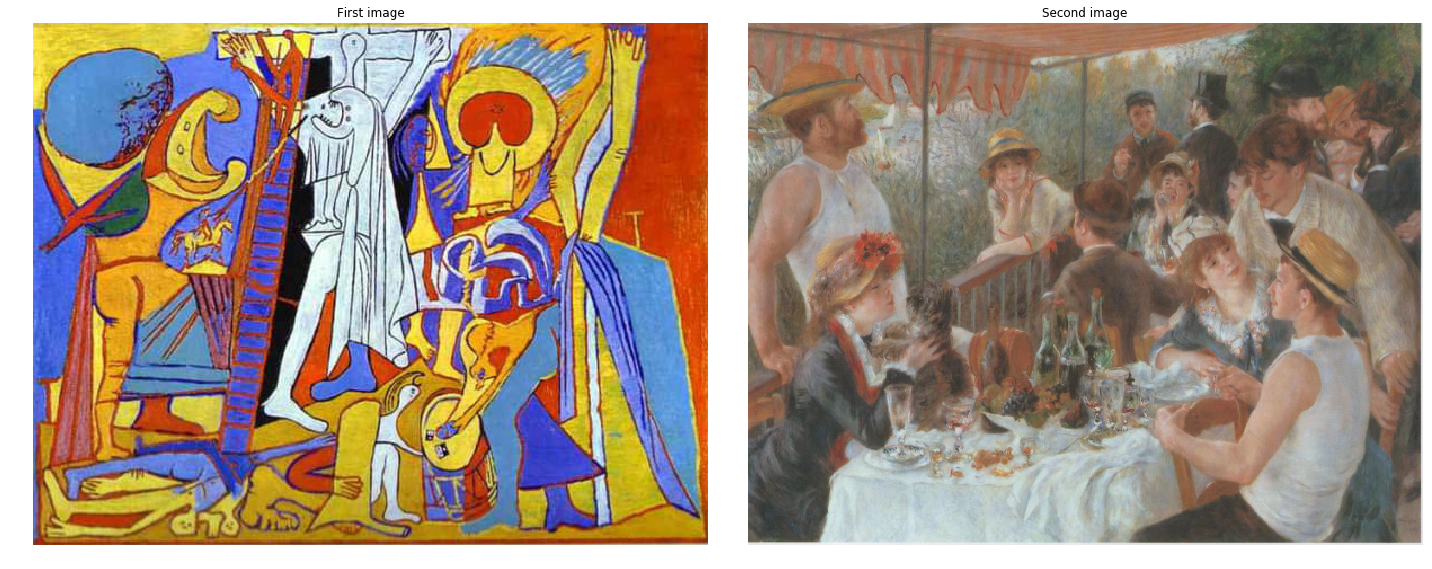

In [2]:
path = './data/'
u = plt.imread(path+'Picasso.jpg')/255
v = plt.imread(path+'renoir.jpg')/255
nr,nc,nch = u.shape
v = resize(v,(nr,nc))

# image display thanks to the function imshow of the pyplot library of matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

#we display the images
axes[0].imshow(u)
axes[0].set_title('First image')
axes[0].axis("off")
axes[1].imshow(v)
axes[1].set_title('Second image')
axes[1].axis("off")
fig.tight_layout()

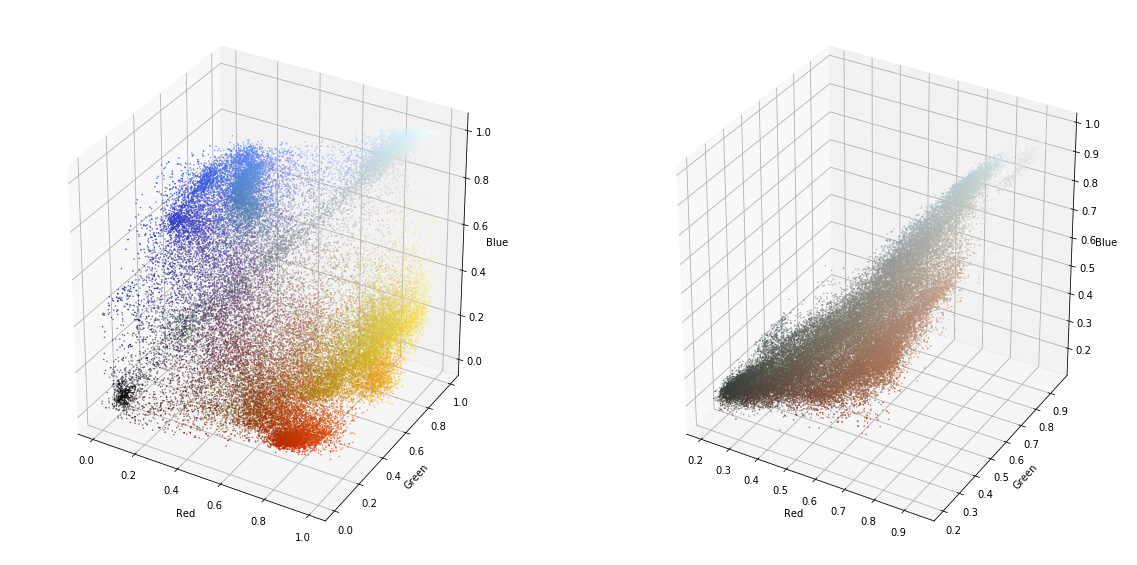

In [3]:
def hist(fig,X,colX,i,T=2, n=50000):
    r    = np.random.RandomState(42)
    idX  = r.randint(X.shape[0], size=(n,))
    Xs   = X[idX, :]
    colXs = colX[idX, :]
    axis = fig.add_subplot(1, T, i, projection="3d")
    axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=colXs, s= 25*500 / len(Xs))
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
 
X = u.reshape((nr*nc,3))
Y = v.reshape((nr*nc,3))
fig  = plt.figure(2, figsize=(20, 10)) 
hist(fig,X,X,1)
hist(fig,Y,Y,2)

# Approximation with Scikit Learn

In [4]:
def GMM_approx(u, k, nr, nc, scikit=True):

    X = u.reshape((nr*nc,3))
    K0 = k # number of classes
    
    if scikit:
        gmmX = sklearn.mixture.GaussianMixture(n_components=K0, verbose=2, init_params="random").fit(X) 
    else:
        gmmX = GaussianMixture(n_components=K0, verbose=1).fit(X)
   
    pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
    ClassesX = gmmX.predict(X) 
    ProbaClassesX = gmmX.predict_proba(X) 
   
    return ClassesX, mu0, pi0, S0, ProbaClassesX

In [14]:
K=8
tic = time.time()
ClassesX_sk, mu0_sk, pi0_sk, S0_sk, ProbaClassesX_sk = GMM_approx(u,K, nr, nc)
toc = time.time()
print("Time first GMM : {}".format(toc-tic))
ClassesY_sk, mu1_sk, pi1_sk, S1_sk, ProbaClassesY_sk = GMM_approx(v,K, nr, nc)
print("Time second GMM : {}".format(time.time()-toc))

Initialization 0
Initialization converged: True	 time lapse 0.59156s	 ll 0.37098
Time first GMM : 1.017603874206543
Initialization 0
Initialization converged: True	 time lapse 0.50651s	 ll 3.74466
Time second GMM : 0.914985179901123


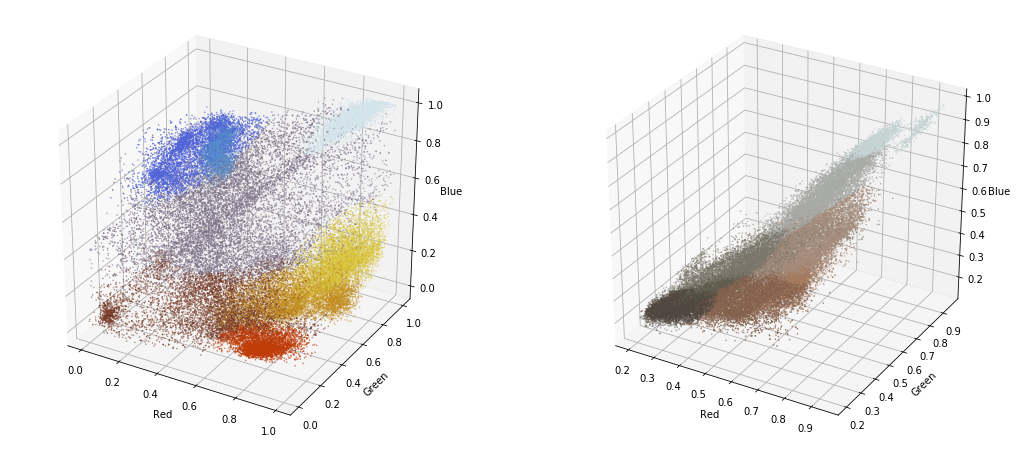

In [6]:
fig  = plt.figure(2, figsize=(18, 8))
colX = mu0_sk[ClassesX_sk,:]
hist(fig,X,colX,1)
colY = mu1_sk[ClassesY_sk,:]
hist(fig,Y,colY,2)

# Approximation with our own package

In [5]:
K = 8
tic = time.time()
ClassesX, mu0, pi0, S0, ProbaClassesX = GMM_approx(u,K, nr, nc, scikit=False)
toc = time.time()
print("Time first GMM : {}".format(toc-tic))
ClassesY, mu1, pi1, S1, ProbaClassesY = GMM_approx(v,K, nr, nc,scikit=False)
print("Time second GMM : {}".format(time.time()-toc))

Log Likelihood : 2.449644165208219 (10/100)
Log Likelihood : 2.895082549751312 (20/100)
Log Likelihood : 2.9875952441799307 (30/100)
Log Likelihood : 3.002569243828612 (40/100)
Log Likelihood : 3.1181580893780847 (50/100)
Convergence in 54
Time first GMM : 13.490287065505981
Log Likelihood : 5.716979895871633 (10/100)
Log Likelihood : 5.843095228034699 (20/100)
Log Likelihood : 5.885121498321024 (30/100)
Log Likelihood : 5.90783712703516 (40/100)
Convergence in 46
Time second GMM : 11.422114133834839


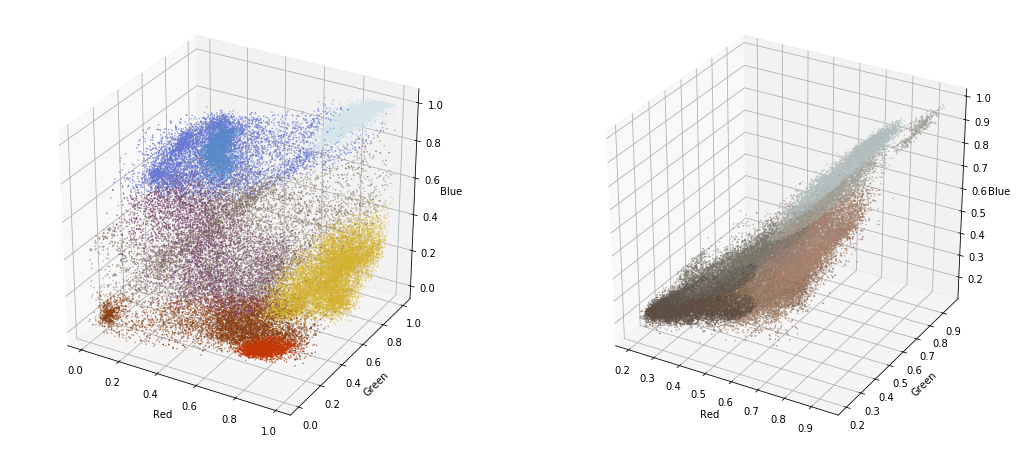

In [8]:
fig  = plt.figure(2, figsize=(18, 8))
colX = mu0[ClassesX,:]
hist(fig,X,colX,1)
colY = mu1[ClassesY,:]
hist(fig,Y,colY,2)

# Color Transfer

In [6]:
w = Transport(X,ClassesX,ClassesY,mu0,mu1,pi0,pi1,S0,S1,ProbaClassesX,ProbaClassesY,nr,nc)

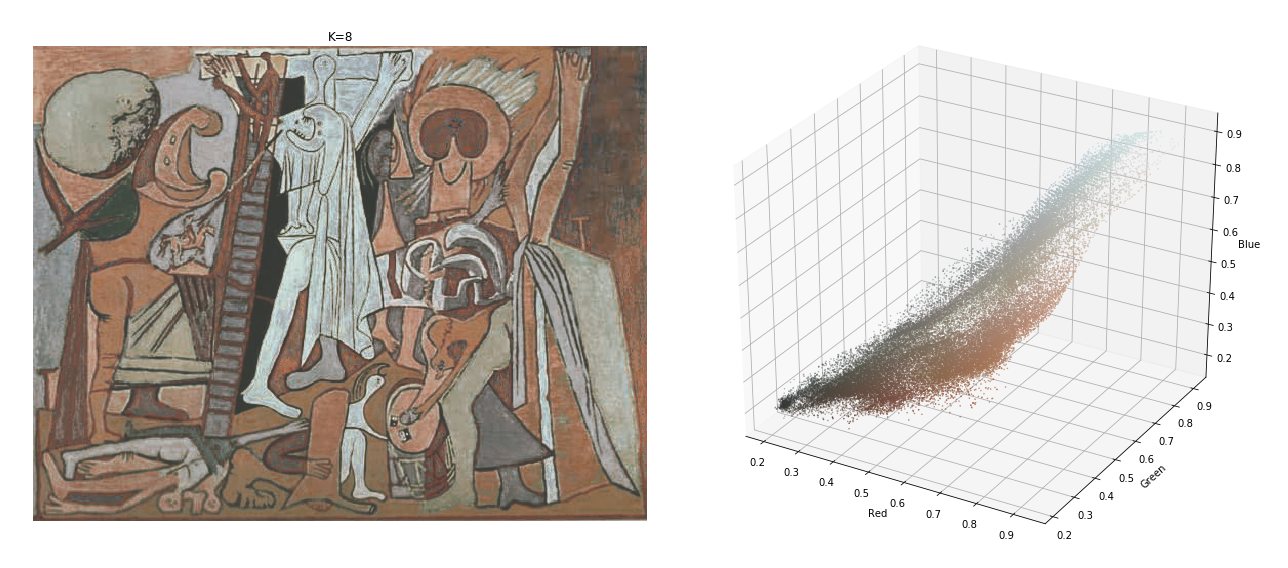

In [7]:
fig  = plt.figure(2, figsize=(18, 8))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(np.clip(w,0,1))
axis.set_title('K=8')
axis.axis("off")

W = w.reshape((w.shape[0]*w.shape[1],3))
W = np.clip(W,0,1)
hist(fig,W,W,2)

fig.tight_layout()
plt.show()

In [11]:
w = Transport(X,ClassesX_sk,ClassesY_sk,mu0_sk,mu1_sk,pi0_sk,pi1_sk,S0_sk,S1_sk,ProbaClassesX_sk,ProbaClassesY_sk,nr,nc)

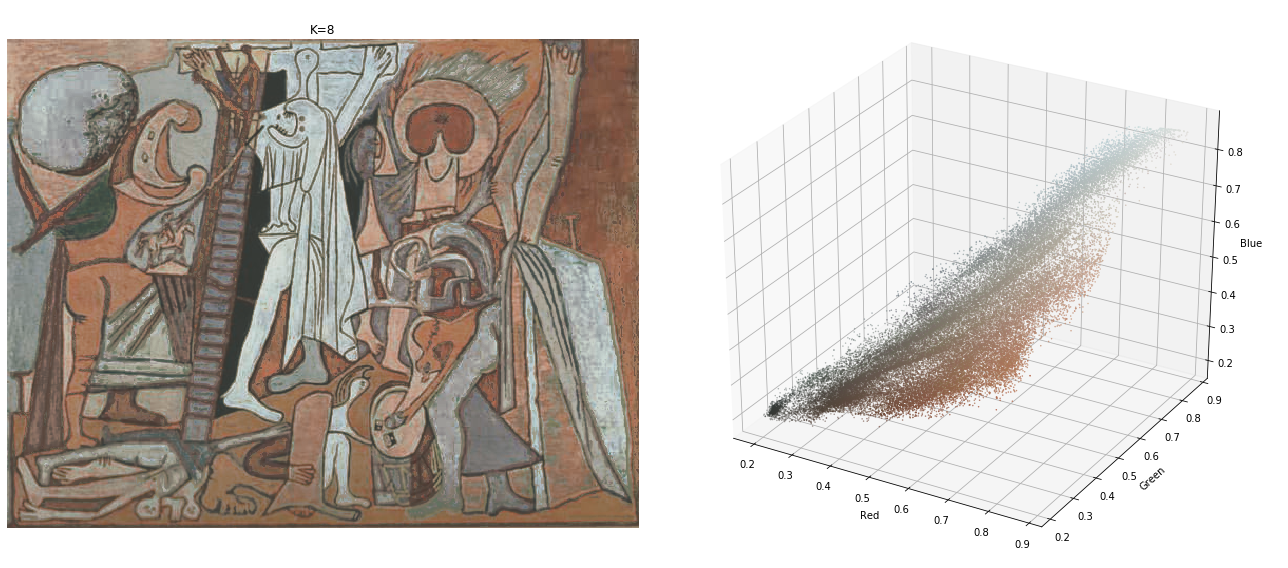

In [12]:
fig  = plt.figure(2, figsize=(18, 8))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(np.clip(w,0,1))
axis.set_title('K=8')
axis.axis("off")

W = w.reshape((w.shape[0]*w.shape[1],3))
W = np.clip(W,0,1)
hist(fig,W,W,2)

fig.tight_layout()
plt.show()